In [2]:
# 1. Imports and Downloads
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import indian
from nltk.tag import tnt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from datasets import load_dataset
import stanfordnlp

nltk.download('indian')
stanfordnlp.download('hi')


[nltk_data] Downloading package indian to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package indian is already up-to-date!


Using the default treebank "hi_hdtb" for language "hi".
Would you like to download the models for: hi_hdtb now? (Y/n)


In [3]:

# 2. Data Loading
def load_data(partition, limit=2000):
    dataset = load_dataset("cfilt/HiNER-collapsed")
    sentences, labels = [], []
    for data in dataset[partition]:
        if len(sentences) >= limit:
            break
        sentences.append(data['tokens'])
        labels.append(data['ner_tags'])
    return sentences, labels

train_sentences, train_labels = load_data('train')
test_sentences, test_labels = load_data('test')


In [4]:

# 3. Data Preprocessing
def initialize_pipeline():
    return stanfordnlp.Pipeline(lang='hi', processors='tokenize,pos')

nlp_pipeline = initialize_pipeline()


Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\91758\\stanfordnlp_resources\\hi_hdtb_models\\hi_hdtb_tokenizer.pt', 'lang': 'hi', 'shorthand': 'hi_hdtb', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\91758\\stanfordnlp_resources\\hi_hdtb_models\\hi_hdtb_tagger.pt', 'pretrain_path': 'C:\\Users\\91758\\stanfordnlp_resources\\hi_hdtb_models\\hi_hdtb.pretrain.pt', 'lang': 'hi', 'shorthand': 'hi_hdtb', 'mode': 'predict'}
Done loading processors!
---


In [5]:

# 4. Feature Extraction
def extract_features(sentences):
    pos_tagger = tnt.TnT()
    train_data = indian.tagged_sents('hindi.pos')
    pos_tagger.train(train_data)
    
    features = []
    for sentence in sentences:
        pos_tags = [tag for _, tag in pos_tagger.tag(sentence)]
        for i, word in enumerate(sentence):
            token_features = {
                'bias': 1.0,
                'POS': pos_tags[i],
                'BOS': i == 0,
                'EOS': i == len(sentence) - 1,
                'prev_word': '' if i == 0 else sentence[i-1].lower(),
                'next_word': '' if i == len(sentence) - 1 else sentence[i+1].lower(),
            }
            features.append(token_features)
    return features

train_features = extract_features(train_sentences)
test_features = extract_features(test_sentences)

v = DictVectorizer(sparse=False)
X_train = v.fit_transform(train_features)
X_test = v.transform(test_features)

pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform([label for sublist in train_labels for label in sublist])
y_test = label_encoder.transform([label for sublist in test_labels for label in sublist])


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3778
           1       0.18      0.19      0.18       508
           2       0.29      0.23      0.26       671
           3       0.42      0.39      0.40       431
           4       0.27      0.26      0.26       349
           5       0.34      0.35      0.34       495
           6       0.95      0.95      0.95     34477

    accuracy                           0.89     40709
   macro avg       0.46      0.45      0.45     40709
weighted avg       0.89      0.89      0.89     40709



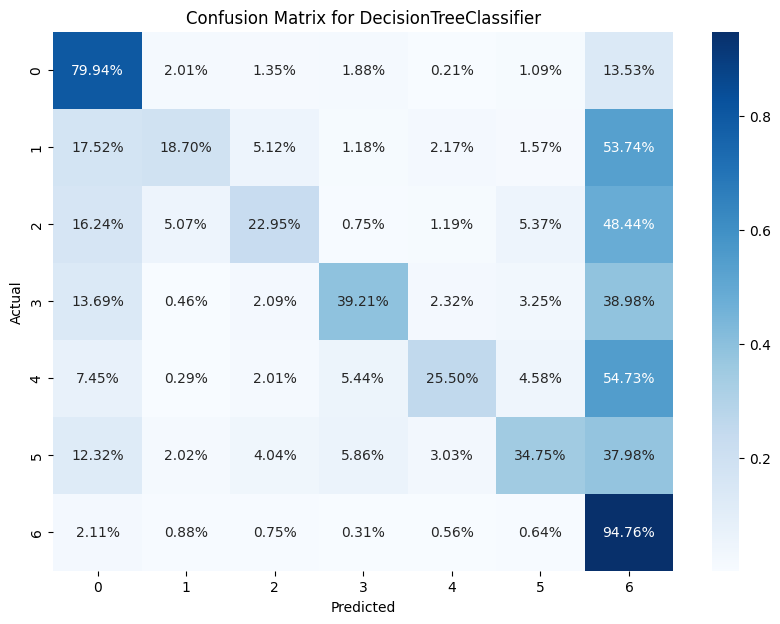

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      3778
           1       0.63      0.14      0.22       508
           2       0.60      0.19      0.29       671
           3       0.81      0.38      0.52       431
           4       0.60      0.19      0.29       349
           5       0.68      0.22      0.33       495
           6       0.93      0.99      0.96     34477

    accuracy                           0.92     40709
   macro avg       0.73      0.41      0.49     40709
weighted avg       0.91      0.92      0.91     40709



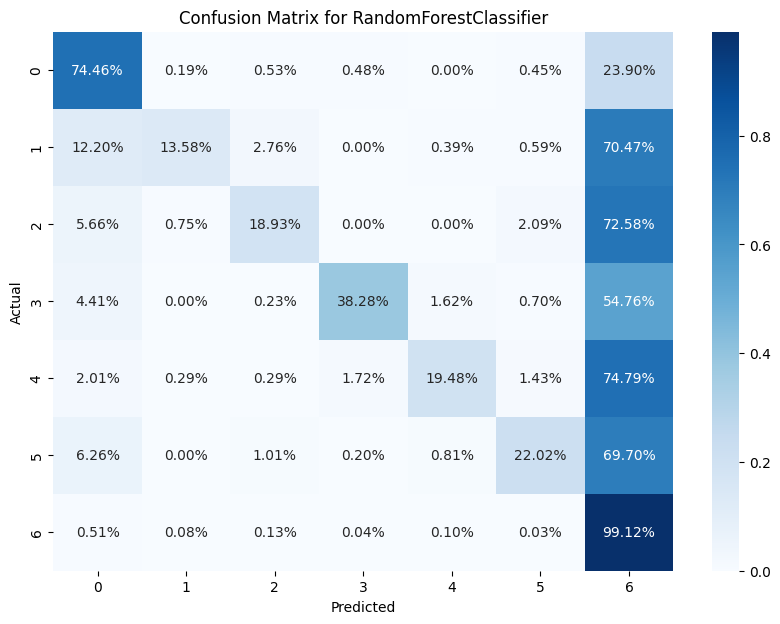

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3778
           1       0.08      0.00      0.00       508
           2       0.50      0.02      0.05       671
           3       0.92      0.23      0.37       431
           4       0.00      0.00      0.00       349
           5       0.44      0.25      0.32       495
           6       0.93      0.98      0.95     34477

    accuracy                           0.91     40709
   macro avg       0.51      0.32      0.35     40709
weighted avg       0.88      0.91      0.89     40709



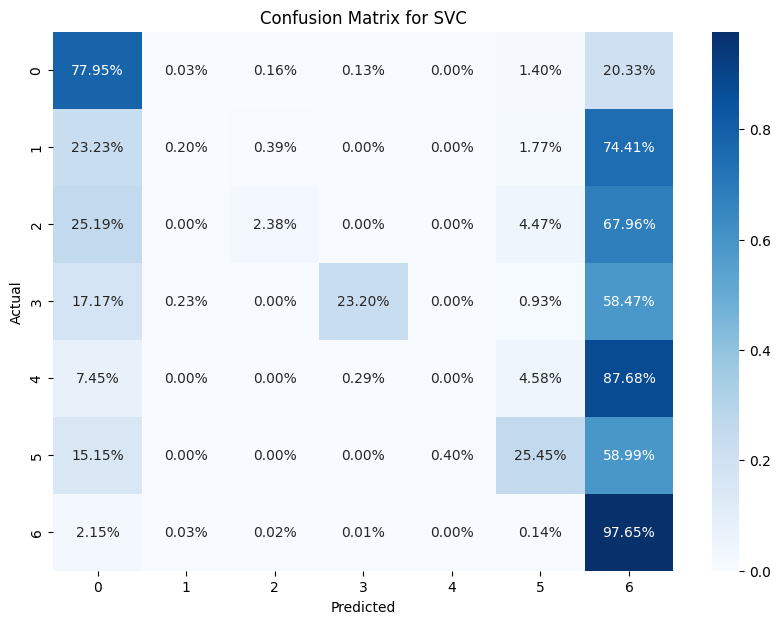

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Prepare labels and target names for reporting
    all_labels = np.unique(np.concatenate([y_train, y_test]))
    target_names = [str(name) for name in label_encoder.inverse_transform(sorted(all_labels))]
    
    # Print classification report
    print(f"Classification Report for {type(model).__name__}:")
    print(classification_report(y_test, y_pred, labels=sorted(all_labels), target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=sorted(all_labels))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Train and evaluate models including Decision Tree, Random Forest, and SVM
models = [DecisionTreeClassifier(random_state=0), RandomForestClassifier(n_estimators=100, random_state=0), SVC(kernel='linear', random_state=0)]
for model in models:
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model)


In [7]:
# Function to display POS, NER tags and features for a specific sentence
def display_sentence_details(sentence_index):
    # Make sure the sentence index is within range
    if sentence_index < 0 or sentence_index >= len(test_sentences):
        print("Sentence index out of range.")
        return
    
    # Sentence
    sentence = test_sentences[sentence_index]
    print("Sentence:", ' '.join(sentence))
    
    # POS Tags
    doc = nlp_pipeline(' '.join(sentence))
    pos_tags = [word.upos for sent in doc.sentences for word in sent.words]
    print("POS Tags:", pos_tags)
    
    # NER Tags
    ner_tags = test_labels[sentence_index]
    print("NER Tags:", ner_tags)
    
    # Extracted Features
    features = extract_features([sentence])
    print("Extracted Features:")
    for feature in features:
        print(feature)

# Example: Display details for the first sentence in the test dataset
display_sentence_details(2)


Sentence: परभूपुर भारत के उत्तर प्रदेश राज्य के इलाहाबाद जिले के हंडिया प्रखण्ड में स्थित एक गाँव है।
POS Tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'PROPN', 'NOUN', 'ADP', 'PROPN', 'NOUN', 'ADP', 'PROPN', 'NOUN', 'ADP', 'ADJ', 'NUM', 'NOUN', 'PUNCT']
NER Tags: [0, 0, 6, 0, 3, 6, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 6]
Extracted Features:
{'bias': 1.0, 'POS': 'Unk', 'BOS': True, 'EOS': False, 'prev_word': '', 'next_word': 'भारत'}
{'bias': 1.0, 'POS': 'NNP', 'BOS': False, 'EOS': False, 'prev_word': 'परभूपुर', 'next_word': 'के'}
{'bias': 1.0, 'POS': 'PREP', 'BOS': False, 'EOS': False, 'prev_word': 'भारत', 'next_word': 'उत्तर'}
{'bias': 1.0, 'POS': 'Unk', 'BOS': False, 'EOS': False, 'prev_word': 'के', 'next_word': 'प्रदेश'}
{'bias': 1.0, 'POS': 'NNC', 'BOS': False, 'EOS': False, 'prev_word': 'उत्तर', 'next_word': 'राज्य'}
{'bias': 1.0, 'POS': 'NN', 'BOS': False, 'EOS': False, 'prev_word': 'प्रदेश', 'next_word': 'के'}
{'bias': 1.0, 'POS': 'PREP', 'BOS': False, 'EOS': False, 'prev_word': 'राज्य', 'n